## Imports

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

ImportError: No module named 'statsmodels'

## Load Dataset

In [3]:
raw_data = pd.read_csv("Online_Retail.csv")
# ,parse_dates=['InvoiceDate']
raw_data.tail(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541899,581587,22726,ALARM CLOCK BAKELIKE GREEN,4,09/12/11 12:50,3.75,12680.0,France
541900,581587,22730,ALARM CLOCK BAKELIKE IVORY,4,09/12/11 12:50,3.75,12680.0,France
541901,581587,22367,CHILDRENS APRON SPACEBOY DESIGN,8,09/12/11 12:50,1.95,12680.0,France
541902,581587,22629,SPACEBOY LUNCH BOX,12,09/12/11 12:50,1.95,12680.0,France
541903,581587,23256,CHILDRENS CUTLERY SPACEBOY,4,09/12/11 12:50,4.15,12680.0,France
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,09/12/11 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,09/12/11 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,09/12/11 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,09/12/11 12:50,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,09/12/11 12:50,4.95,12680.0,France


## Convert to Time series data

In [4]:
sales_data = raw_data.drop(['InvoiceNo','Description','CustomerID','Country','UnitPrice'], axis = 1)
sales_data['InvoiceDate'] = pd.to_datetime(sales_data['InvoiceDate'])
# sales_data=sales_data.set_index(['InvoiceDate'])
sales_data.info()
sales_data.index
# sales_data.head(100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 3 columns):
StockCode      541909 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 12.4+ MB


RangeIndex(start=0, stop=541909, step=1)

In [5]:
# dates = sales_data.drop(['StockCode','Quantity'],axis =1)
# dates['InvoiceDate'] = pd.to_datetime(dates['InvoiceDate'])
# dates['InvoiceDate'] = dates['InvoiceDate'].dt.date

In [6]:
# (dates.InvoiceDate.min(),dates.InvoiceDate.max())
# dates.head()

### Extracting one product out and DownSampling

In [7]:
def extract_product(product_id):
    #pull out all transactions of one product and drop StockCode
    product = sales_data.loc[sales_data['StockCode'] == product_id].drop('StockCode',axis=1)
    product=product.set_index(['InvoiceDate']) #Convert to timeseries 

    #DownSampling to a day
    day_summary = pd.DataFrame()
    day_summary['Quantity'] = product.Quantity.resample('W').sum()
    day_summary = day_summary.fillna(0) #replacing NaN with 0
    day_summary = day_summary.clip(0) #replace -ve values with 0

    day_summary = day_summary['2010-12-12':]#trim as almost no data available before this date
    day_summary['Quantity']+=1#ti avoid -inf while taking log transformation 
    print(day_summary.describe())
    #plot
    fig, ax1 = plt.subplots()
    ax1.plot(day_summary.index, day_summary['Quantity'])
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Quantity')
    # ax1.set_ylim(0,100)
    plt.show()
    return day_summary
# extract_product(str(22661))

## Stationarity check

In [8]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=5)
    rolstd = pd.rolling_std(timeseries, window=5)

#     #Plot rolling statistics:
#     orig = plt.plot(timeseries, color='blue',label='Original')
#     mean = plt.plot(rolmean, color='red', label='Rolling Mean')
#     std = plt.plot(rolstd, color='black', label = 'Rolling Std')
#     plt.legend(loc='best')
#     plt.title('Rolling Mean & Standard Deviation')
#     plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries,autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    if dfoutput[0]<dfoutput[4]:
        print("90% Stationary")
    elif dfoutput[0]<dfoutput[5]:
        print("99% Stationary")
    elif dfoutput[0]<dfoutput[6]:
        print("95% Stationary")
    else:
        print("not Stationary")
    
# test_stationarity(day_summary.Quantity)

## Eliminating Trend

### exponential weighted moving average

In [9]:
def log_tranformation(ts):
    return np.log(ts)

# day_summary_log = log_tranformation(day_summary)
# print(day_summary_log.head())

def ewma_diff(ts,halflife):
    expwighted_avg = pd.ewma(ts, halflife=halflife)
    ts_log_ewma_diff = ts - expwighted_avg
    ts_log_ewma_diff = ts_log_ewma_diff.clip(0)
    plt.plot(ts_log_ewma_diff)
    return ts_log_ewma_diff
# day_summary_log_ewma_diff = ewma_diff(day_summary_log,5)
# test_stationarity(day_summary_log_ewma_diff.Quantity)


As we can see Simple methods like Log transformation and exponential weighted moving average does not help in improving stationarity in our case

### Differencing

In [10]:
def differencing(ts):
    ts_diff = ts - ts.shift()
    ts_diff.dropna(inplace=True)
    plt.plot(ts_diff)
    plt.show()
    return ts_diff
# day_summary_log_diff = day_summary_log_diff.fillna(0) #replacing NaN with 0
# day_summary_log_diff = day_summary_log_diff.clip(0)
# day_summary_log_diff = differencing(day_summary_log)
# print(day_summary_log_diff.head())
# test_stationarity(day_summary_log_diff.Quantity)

Because of the nature of our series there is no significant increase in Stationary values but we have sucesfully removed seasonality and trends from our series.

## ARIMA
### ACF and PACF

In [11]:
#ACF and PACF plots:
def get_p_and_q(ts):
    lag_acf = acf(ts, nlags=5)
    lag_pacf = pacf(ts, nlags=5, method='ols')
    confidence_lines = (-1.96/np.sqrt(len(ts)),1.96/np.sqrt(len(ts)))

    def get_value(lag):
        for i in range(len(lag)):
            if lag[i]<confidence_lines[1]:
                return i
    #calculating value of p
    p = get_value(lag_pacf)
    #calculating value of p
    q=get_value(lag_acf)
    
    #Plot ACF: 
    plt.subplot(121) 
    plt.plot(lag_acf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
    plt.title('Autocorrelation Function')


    #Plot PACF:
    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
    plt.title('Partial Autocorrelation Function')
    plt.tight_layout()

    return (p,q)





# p,q = get_p_and_q(day_summary_log_diff)    
# d=1 #as differencing lag was 1
# print((p,q,d))

### AR Model

In [12]:
def AR_model(ts,ts_diff):
    model = ARIMA(ts, order=(p, d, 0))  
    results_AR = model.fit(disp=-1)  
    plt.plot(ts_diff)
    plt.plot(results_AR.fittedvalues, color='red')
    plt.title('RMSE: %.4f'% np.sqrt(sum((results_AR.fittedvalues-ts_diff.Quantity)**2)/len(ts_diff)))
#     np.sqrt(sum((predictions_ARIMA-day_summary.Quantity)**2)/len(day_summary)))
    plt.show()
    return results_AR

# results_AR = AR_model(day_summary_log,day_summary_log_diff)

### MA Model

In [13]:
def MA_model(ts,ts_diff):
    model = ARIMA(ts, order=(0, d, q))  
    results_MA = model.fit(disp=-1)  
    plt.plot(ts_diff)
    plt.plot(results_MA.fittedvalues, color='red')
    plt.title('RMSE: %.4f'% np.sqrt(sum((results_MA.fittedvalues-ts_diff.Quantity)**2)/len(ts_diff)))
    plt.show()
    return results_MA


# results_MA = MA_model(day_summary_log,day_summary_log_diff)

### Combined Model

In [14]:
def ARIMA_model(ts,ts_diff):
    model = ARIMA(ts, order=(p, d, q))  
    results_ARIMA = model.fit(disp=-1)  
    plt.plot(ts_diff)
    plt.plot(results_ARIMA.fittedvalues, color='red')
    plt.title('RMSE: %.4f'% np.sqrt(sum((results_ARIMA.fittedvalues-ts_diff.Quantity)**2)/len(ts_diff)))
    plt.show()
    return results_ARIMA

# results_ARIMA = ARIMA_model(day_summary_log,day_summary_log_diff)

## Taking it back to original scale

In [15]:
def take_back_to_original_scale(model_result):
    predictions_ARIMA_diff = pd.Series(model_result.fittedvalues, copy=True)
#     print(predictions_ARIMA_diff.head())

    predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
#     print(predictions_ARIMA_diff_cumsum.head())
    
    predictions_ARIMA_log = pd.Series(day_summary.iloc[0], index=day_summary.index)
    predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
    predictions_ARIMA_log[0] = day_summary.Quantity[0]
    print(predictions_ARIMA_log.head())
    
#     predictions_ARIMA = np.exp(predictions_ARIMA_log)
#     plt.ylim(0,30)
    predictions_ARIMA = predictions_ARIMA_log
    plt.plot(day_summary)
    plt.plot(predictions_ARIMA)
    plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-day_summary.Quantity)**2)/len(day_summary)))
    plt.show()

## MAIN

         Quantity
count   53.000000
mean   114.943396
std    104.601702
min      2.000000
25%     54.000000
50%     83.000000
75%    136.000000
max    491.000000


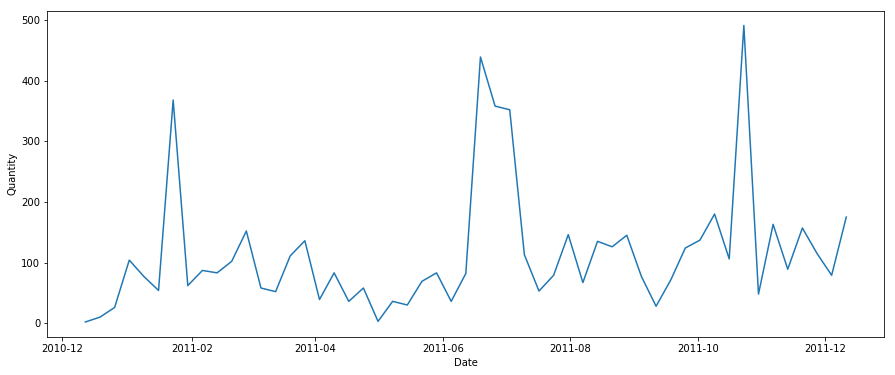

In [19]:
day_summary = extract_product('21121')
# test_stationarity(day_summary.Quantity)
# day_summary_log = log_tranformation(day_summary)
# day_summary_log_ewma_diff = ewma_diff(day_summary_log,5)
# test_stationarity(day_summary_log_ewma_diff.Quantity)
# day_summary_log_diff = differencing(day_summary_log)
# test_stationarity(day_summary_log_diff.Quantity)
# day_summary_diff = differencing(day_summary)
# day_summary_diff = differencing(day_summary)
# test_stationarity(day_summary_diff.Quantity)
# p,q = get_p_and_q(day_summary_log_diff)    
# d=1 #as differencing lag was 1
# print((p,q,d))



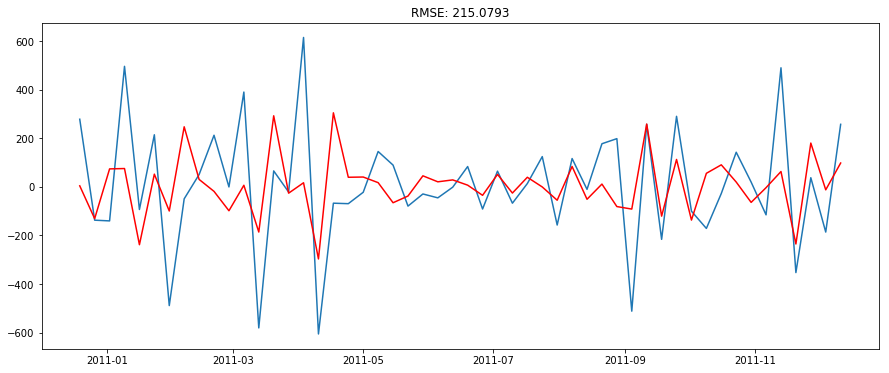

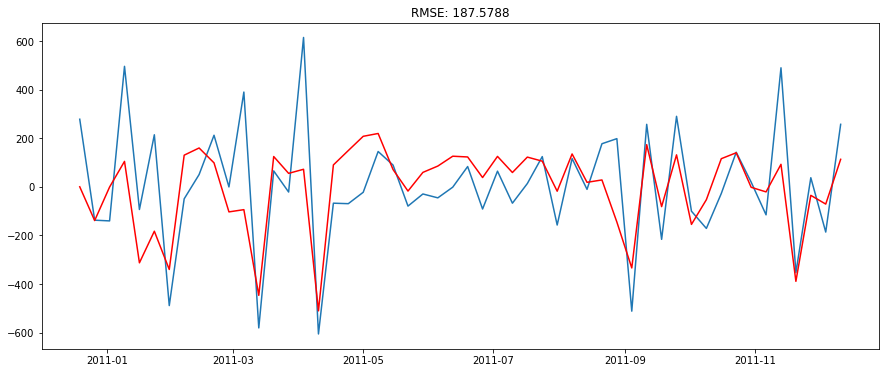

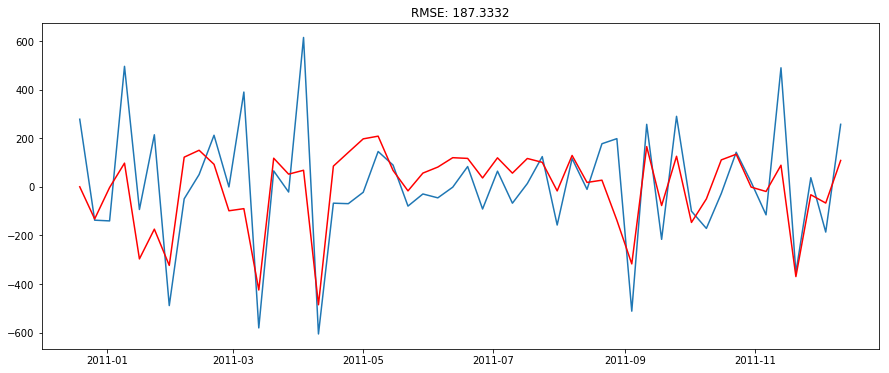

InvoiceDate
2010-12-12      6.000000
2010-12-19      4.571728
2010-12-26   -126.099433
2011-01-02    -51.758767
2011-01-09     24.060350
Freq: W-SUN, dtype: float64


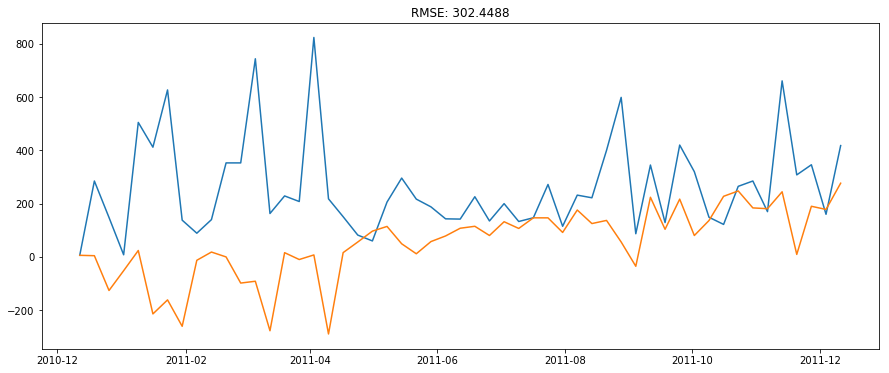

InvoiceDate
2010-12-12      6.000000
2010-12-19      0.618048
2010-12-26   -137.954880
2011-01-02   -138.385450
2011-01-09    -33.090330
Freq: W-SUN, dtype: float64


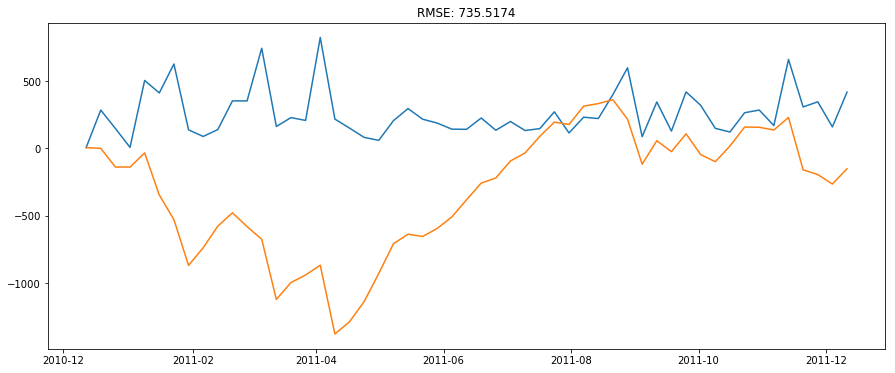

InvoiceDate
2010-12-12      6.000000
2010-12-19      0.658892
2010-12-26   -131.278623
2011-01-02   -133.693486
2011-01-09    -35.658134
Freq: W-SUN, dtype: float64


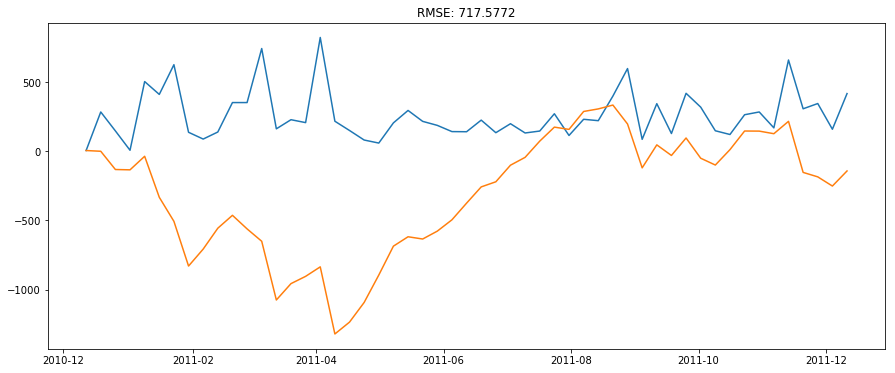

In [45]:

# results_AR = AR_model(day_summary_log,day_summary_log_diff)
# results_MA = MA_model(day_summary_log,day_summary_log_diff)
# results_ARIMA = ARIMA_model(day_summary_log,day_summary_log_diff)

results_AR = AR_model(day_summary,day_summary_diff)
results_MA = MA_model(day_summary,day_summary_diff)
results_ARIMA = ARIMA_model(day_summary,day_summary_diff)


take_back_to_original_scale(results_AR)
take_back_to_original_scale(results_MA)
take_back_to_original_scale(results_ARIMA)
